In [1]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

In [2]:
# creating custom dataset
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image

In [3]:
# directory paths
root_dir = "images"
results_dir = "results"

In [4]:
# loading the transform that was applied to ImageNet dataset
transform = torchvision.models.AlexNet_Weights.IMAGENET1K_V1.transforms()
# loading the dataset
dataset = ImageDataset(root_dir, transform)
# loading the dataset into dataloader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

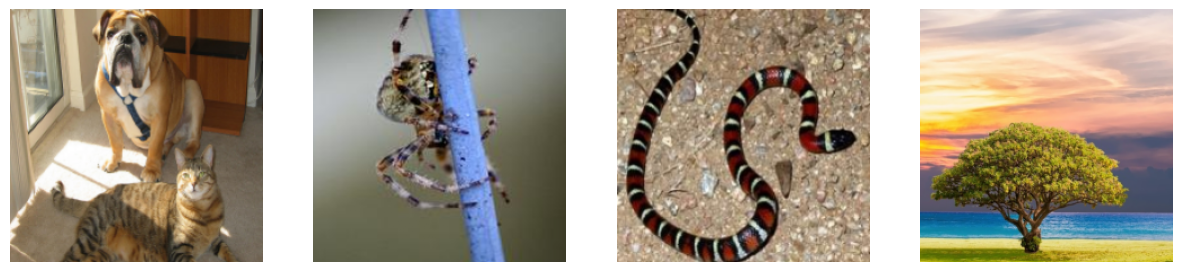

In [5]:
# viweing the dataset
for images in dataloader:
    mean = torch.tensor([0.485, 0.456, 0.406]) 
    std = torch.tensor([0.229, 0.224, 0.225])

    images_unnormalized = images * std.view(1, 3, 1, 1) + mean.view(1, 3, 1, 1)
    images_unnormalized = torch.clamp(images_unnormalized, 0, 1)
    images_unnormalized = images_unnormalized.permute(0, 2, 3, 1)

    batch_size = images_unnormalized.shape[0]
    fig, axes = plt.subplots(nrows=1, ncols=batch_size, figsize=(15, 5))

    for i in range(batch_size):
        image = images_unnormalized[i].numpy()
        axes[i].imshow(image)
        axes[i].axis("off")

    plt.show()

In [6]:
# creating a modified alexnet that also return switches(indices where max pooling was applied) and output from each layer
class Modified_AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5):
        super(Modified_AlexNet, self).__init__()

        self.L1_C = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.L1_R = nn.ReLU(inplace=True)
        self.L1_P = nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True)

        self.L2_C = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.L2_R = nn.ReLU(inplace=True)
        self.L2_P = nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True)

        self.L3_C = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.L3_R = nn.ReLU(inplace=True)

        self.L4_C = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.L4_R = nn.ReLU(inplace=True)

        self.L5_C = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.L5_R = nn.ReLU(inplace=True)
        self.L5_P = nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True)

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        # Unpooling layers
        self.L1_U = nn.MaxUnpool2d(kernel_size=3, stride=2)
        self.L2_U = nn.MaxUnpool2d(kernel_size=3, stride=2)
        self.L5_U = nn.MaxUnpool2d(kernel_size=3, stride=2)

    def forward(self, x):
        switches = {}
        
        x = self.L1_C(x)
        x = self.L1_R(x)
        x, switches['L1_P'] = self.L1_P(x)
        x_l1 = x
        x = self.L2_C(x)
        x = self.L2_R(x)
        x, switches['L2_P'] = self.L2_P(x)
        x_l2 = x
        x = self.L3_C(x)
        x = self.L3_R(x)
        x_l3 = x
        x = self.L4_C(x)
        x = self.L4_R(x)
        x_l4 = x
        x = self.L5_C(x)
        x = self.L5_R(x)
        x, switches['L5_P'] = self.L5_P(x)
        x_l5 = x
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, switches, [x_l1, x_l2, x_l3, x_l4, x_l5]

    def reconstruct_from_l5(self, switches, x_l5):
        x = self.L5_U(x_l5, switches['L5_P'])
        x = F.relu(x)
        x = F.conv_transpose2d(x, self.L5_C.weight, padding=1)
        x = F.relu(x)
        
        x = F.conv_transpose2d(x, self.L4_C.weight, padding=1)
        x = F.relu(x)
        
        x = F.conv_transpose2d(x, self.L3_C.weight, padding=1)
        x = F.relu(x)
        
        x = self.L2_U(x, switches['L2_P'])
        x = F.relu(x)
        x = F.conv_transpose2d(x, self.L2_C.weight, padding=2)
        x = F.relu(x)
        
        x = self.L1_U(x, switches['L1_P'])
        x = F.relu(x)
        x = F.conv_transpose2d(x, self.L1_C.weight, stride=4, padding=2, output_padding=1)
        x = F.relu(x)
        
        return x
        
    def reconstruct_from_l4(self, switches, x_l4):
        x = F.conv_transpose2d(x_l4, self.L4_C.weight, padding=1)
        x = F.relu(x)
        
        x = F.conv_transpose2d(x, self.L3_C.weight, padding=1)
        x = F.relu(x)
        
        x = self.L2_U(x, switches['L2_P'])
        x = F.relu(x)
        x = F.conv_transpose2d(x, self.L2_C.weight, padding=2)
        x = F.relu(x)
        
        x = self.L1_U(x, switches['L1_P'])
        x = F.relu(x)
        x = F.conv_transpose2d(x, self.L1_C.weight, stride=4, padding=2, output_padding=1)
        x = F.relu(x)
        
        return x

    def reconstruct_from_l3(self, switches, x_l3):
        x = F.conv_transpose2d(x_l3, self.L3_C.weight, padding=1)
        x = F.relu(x)
        
        x = self.L2_U(x, switches['L2_P'])
        x = F.relu(x)
        x = F.conv_transpose2d(x, self.L2_C.weight, padding=2)
        x = F.relu(x)
        
        x = self.L1_U(x, switches['L1_P'])
        x = F.relu(x)
        x = F.conv_transpose2d(x, self.L1_C.weight, stride=4, padding=2, output_padding=1)
        x = F.relu(x)
        
        return x

    def reconstruct_from_l2(self, switches, x_l2):
        x = self.L2_U(x_l2, switches['L2_P'])
        x = F.relu(x)
        x = F.conv_transpose2d(x, self.L2_C.weight, padding=2)
        x = F.relu(x)
        
        x = self.L1_U(x, switches['L1_P'])
        x = F.relu(x)
        x = F.conv_transpose2d(x, self.L1_C.weight, stride=4, padding=2, output_padding=1)
        x = F.relu(x)
        
        return x

    def reconstruct_from_l1(self, switches, x_l1):
        x = self.L1_U(x_l1, switches['L1_P'])
        x = F.relu(x)
        x = F.conv_transpose2d(x, self.L1_C.weight, stride=4, padding=2, output_padding=1)
        x = F.relu(x)
        
        return x

In [7]:
# this function sets the weights of the untrained model equal to those of the pretrained model
def weight_transfer(model):
    pretrained_model = models.alexnet(weights="IMAGENET1K_V1", progress=True)

    pretrained_model_state = pretrained_model.state_dict()
    model_state = model.state_dict()

    for trained_layer_name, trained_layer_weights in pretrained_model_state.items():
        for new_layer_name, new_layer_weights in model_state.items():
            if trained_layer_name=="features.0.weight" and new_layer_name=="L1_C.weight":
                model_state[new_layer_name] = trained_layer_weights
            elif trained_layer_name=="features.0.bias" and new_layer_name=="L1_C.bias":
                model_state[new_layer_name] = trained_layer_weights
            elif trained_layer_name=="features.3.weight" and new_layer_name=="L2_C.weight":
                model_state[new_layer_name] = trained_layer_weights
            elif trained_layer_name=="features.3.bias" and new_layer_name=="L2_C.bias":
                model_state[new_layer_name] = trained_layer_weights 
            elif trained_layer_name=="features.6.weight" and new_layer_name=="L3_C.weight":
                model_state[new_layer_name] = trained_layer_weights 
            elif trained_layer_name=="features.6.bias" and new_layer_name=="L3_C.bias":
                model_state[new_layer_name] = trained_layer_weights 
            elif trained_layer_name=="features.8.weight" and new_layer_name=="L4_C.weight":
                model_state[new_layer_name] = trained_layer_weights 
            elif trained_layer_name=="features.8.bias" and new_layer_name=="L4_C.bias":
                model_state[new_layer_name] = trained_layer_weights 
            elif trained_layer_name=="features.10.weight" and new_layer_name=="L5_C.weight":
                model_state[new_layer_name] = trained_layer_weights 
            elif trained_layer_name=="features.10.bias" and new_layer_name=="L5_C.bias":
                model_state[new_layer_name] = trained_layer_weights 
            elif trained_layer_name==new_layer_name:
                model_state[new_layer_name] = trained_layer_weights

    model.load_state_dict(model_state)
    return model

In [8]:
# creating an instance of the modified alexnet model
model = Modified_AlexNet()
# transferring the weights from pretrained alexnet model to modified alexnet model
model = weight_transfer(model)

In [9]:
def view_layer_outputs(images, title, save_path):
    mean = torch.tensor([0.485, 0.456, 0.406]) 
    std = torch.tensor([0.229, 0.224, 0.225])

    images_unnormalized = images * std.view(1, 3, 1, 1) + mean.view(1, 3, 1, 1)
    images_unnormalized = torch.clamp(images_unnormalized, 0, 1)
    images_unnormalized = images_unnormalized.permute(0, 2, 3, 1)

    batch_size = images_unnormalized.shape[0]
    fig, axes = plt.subplots(nrows=1, ncols=batch_size, figsize=(15, 5))

    for i in range(batch_size):
        image = images_unnormalized[i].numpy()
        axes[i].imshow(image)
        axes[i].axis("off")
    fig.suptitle(title, fontsize=16, y=0.8) 
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

In [10]:
# this function saves the reconstructed images from different layers
def get_results(model, results_dir, dataloader):
    model.train()

    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    for images in dataloader:
        x, switches, [x_l1, x_l2, x_l3, x_l4, x_l5] = model(images)

        results_layer1_dir = os.path.join(results_dir, "layer1.png")
        reconstruct_output_layer_1 = model.reconstruct_from_l1(switches, x_l1)
        view_layer_outputs(reconstruct_output_layer_1.detach(), "Layer 1 Outputs", results_layer1_dir)

        results_layer2_dir = os.path.join(results_dir, "layer2.png")
        reconstruct_output_layer_2 = model.reconstruct_from_l2(switches, x_l2)
        view_layer_outputs(reconstruct_output_layer_2.detach(), "Layer 2 Outputs", results_layer2_dir)

        results_layer3_dir = os.path.join(results_dir, "layer3.png")
        reconstruct_output_layer_3 = model.reconstruct_from_l3(switches, x_l3)
        view_layer_outputs(reconstruct_output_layer_3.detach(), "layer 3 Outputs", results_layer3_dir)

        results_layer4_dir = os.path.join(results_dir, "layer4.png")
        reconstruct_output_layer_4 = model.reconstruct_from_l4(switches, x_l4)
        view_layer_outputs(reconstruct_output_layer_4.detach(), "Layer 4 Outputs", results_layer4_dir)

        results_layer5_dir = os.path.join(results_dir, "layer5.png")
        reconstruct_output_layer_5 = model.reconstruct_from_l5(switches, x_l5)
        view_layer_outputs(reconstruct_output_layer_5.detach(), "Layer 5 Outputs", results_layer5_dir)

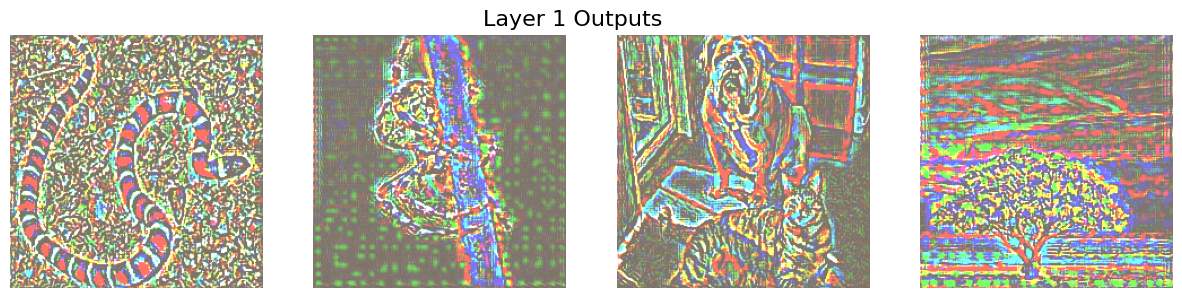

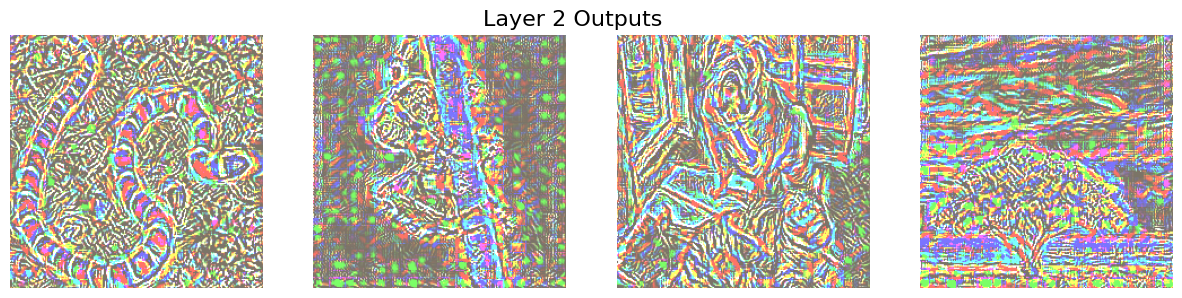

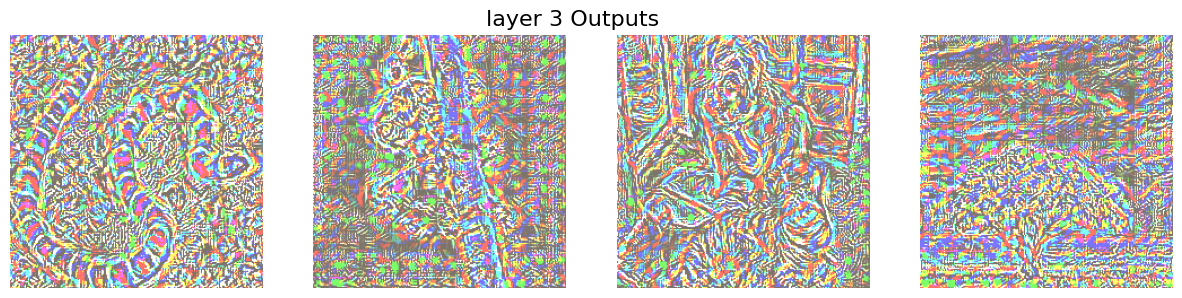

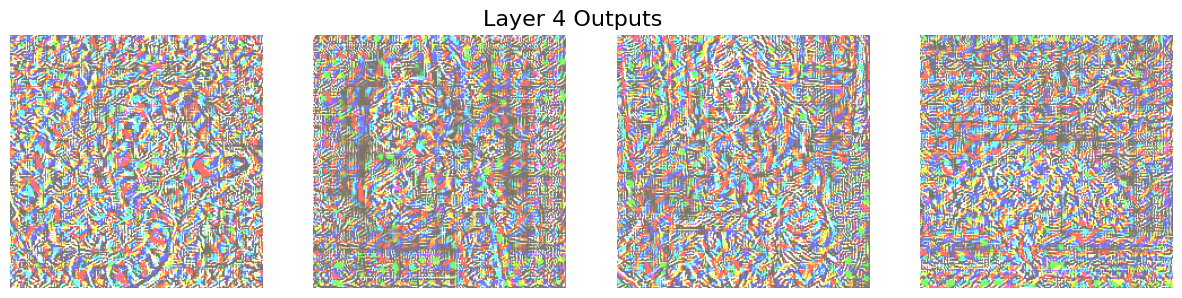

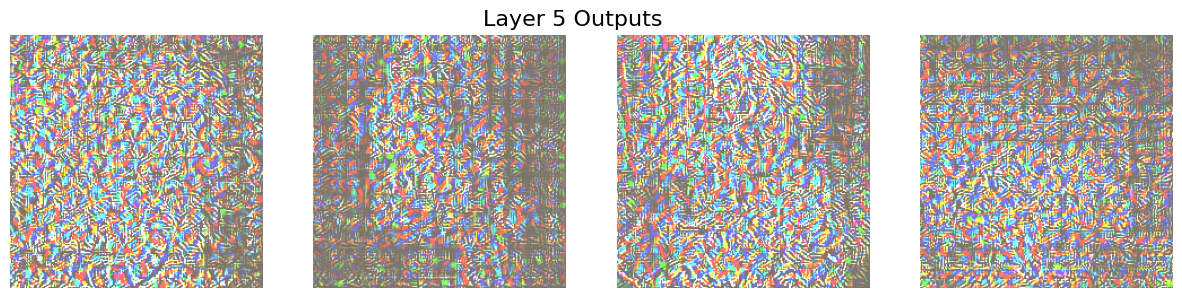

In [11]:
get_results(model, results_dir, dataloader)